In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Libraries for SVM implementation
from scipy.spatial import distance
import copy
from scipy.linalg import cho_factor, cho_solve, eigh
from scipy import optimize

# Libraries for gridsearch
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Library to estimate the execution time
from tqdm import tqdm
from itertools import combinations

In [3]:
random.seed(42)

In [4]:
def reconstructImage(data):

    nb, N = data.shape
    red_channel = data[:,:N//3]
    min_red = red_channel.min(1).reshape(-1,1)
    max_red = red_channel.max(1).reshape(-1,1)
    red_channel = (red_channel-min_red)/(max_red-min_red)

    green_channel = data[:,N//3:2*N//3]
    min_green = green_channel.min(1).reshape(-1,1)
    max_green = green_channel.max(1).reshape(-1,1)
    green_channel = (green_channel-min_green)/(max_green-min_green)

    blue_channel = data[:,2*N//3:]
    min_blue = blue_channel.min(1).reshape(-1,1)
    max_blue = blue_channel.max(1).reshape(-1,1)
    blue_channel = (blue_channel-min_blue)/(max_blue-min_blue)

    newdata = np.hstack((red_channel,green_channel,blue_channel))
    newdata = newdata.reshape(nb,3,32,32).transpose(0,2,3,1)
    return newdata

In [5]:
def plot_image(data, index):

    row = data.iloc[index].values
    N = row.shape[0]
    red_channel = row[:N//3].reshape(-1,1)
    min_value = red_channel.min()
    max_value = red_channel.max()
    red_channel = np.array(1*(red_channel - min_value)/(max_value-min_value))

    green_channel = row[N//3:2*N//3].reshape(-1,1)
    min_value = green_channel.min()
    max_value = green_channel.max()


    green_channel = np.array(1*(green_channel - min_value)/(max_value-min_value))


    blue_channel = row[2*N//3:].reshape(-1,1)
    min_value = blue_channel.min()
    max_value = blue_channel.max()
    blue_channel = np.array(1*(blue_channel - min_value)/(max_value-min_value))


    image = np.hstack((red_channel,green_channel,blue_channel))
    image = image.reshape(32,32,3)
    plt.figure(figsize=(8,8))
    plt.imshow(image)

In [6]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [7]:
def create_Submissioncsv(y_test):

    f = open("result/Yte.csv", "w")
    f.write("Id,Prediction\n")
    for n in range(len(y_test)):
        f.write("{},{}\n".format(int(n+1),y_test[n]))
    f.close()

In [8]:
def scaler(X_train, X_val = None, X_test = None):

    mu_X = X_train.mean()
    sigma_X = X_train.std()

    return (X_train - mu_X)/sigma_X, (X_val - mu_X)/sigma_X, (X_test - mu_X)/sigma_X

In [9]:
def inspect_label(labels):
  unique_elements, counts = np.unique(labels, return_counts=True)
  plt.bar(unique_elements, counts, color='skyblue')
  plt.show()

In [10]:
test_set = np.array(pd.read_csv('/content/drive/My Drive/Challenge Kernel method/Xte.csv',header=None,sep=',',usecols=range(3072)))

train_set = np.array(pd.read_csv('/content/drive/My Drive/Challenge Kernel method/Xtr.csv',header=None,sep=',',usecols=range(3072)))

train_label = np.array(pd.read_csv('/content/drive/My Drive/Challenge Kernel method/Ytr.csv',sep=',',usecols=[1])).squeeze()

In [11]:
print(f'test set size: {test_set.shape}')
print(f'train set size: {train_set.shape}')
print(f'train set labet size: {train_label.shape}')

test set size: (2000, 3072)
train set size: (5000, 3072)
train set labet size: (5000,)


In [12]:
train_set, val_set, train_label, val_label = train_test_split(train_set, train_label, test_size=.2)

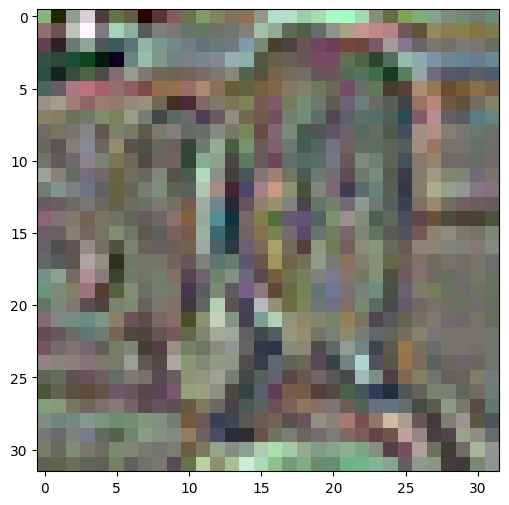

In [13]:
newdata_train = reconstructImage(train_set)
newdata_val = reconstructImage(val_set)
newdata_test = reconstructImage(test_set)

plt.figure(figsize=(6,6))
plt.imshow(newdata_train[10])
plt.show()


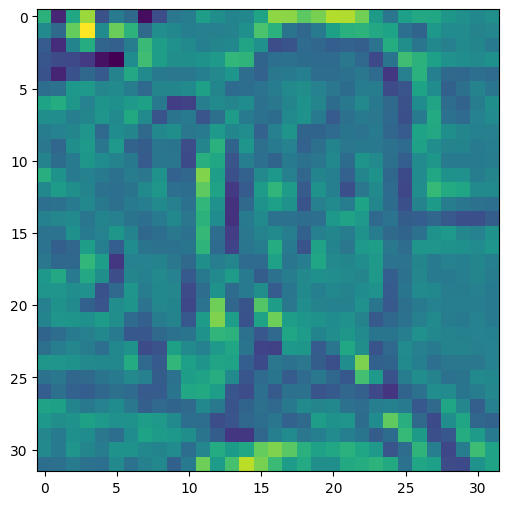

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(rgb2gray(newdata_train[10]))
plt.show()

# SVM with different Kernel (Gaussian and polynomial)

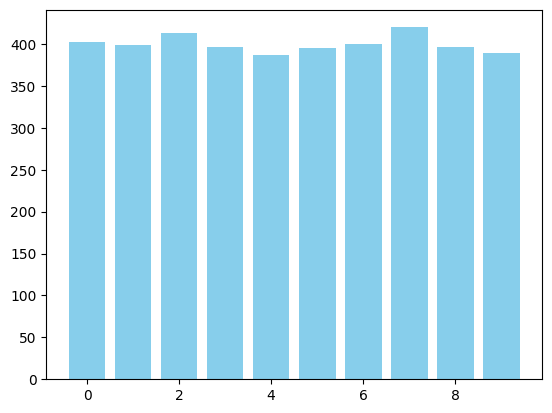

In [15]:
inspect_label(train_label)

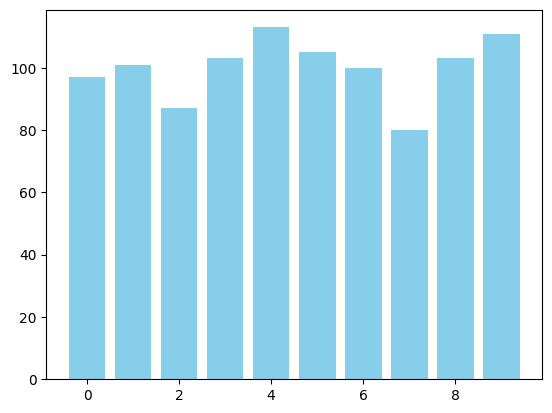

In [16]:
inspect_label(val_label)

In [17]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self, X, Y):
        XX = np.sum(X**2, axis=1)[:, np.newaxis]
        YY = np.sum(Y**2, axis=1)[np.newaxis, :]
        distances = XX + YY - 2 * X.dot(Y.T)
        return np.exp(-distances / (2 * self.sigma**2))

In [18]:
class Linear:
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return  X@Y.T## Matrix of shape NxM

In [19]:
class Polynomial:
    def __init__(self, d = 3, cst = 0):
        self.d = d  ## the degree of the polynomial
        self.cst = cst  ## trading parameter
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return np.power(X @ Y.T + self.cst,self.d)

In [20]:
from re import M
class KernelPCA:

    def __init__(self,kernel, r=2):
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r =r ## Number of principal components
    def compute_PCA(self, X):
        # assigns the vectors
        self.support = X
        self.N = X.shape[0]
        K = self.kernel(self.support, self.support)
        I = np.eye(self.N)
        U =  (1/self.N) * np.ones((self.N, self.N))
        G = ((I - U) @ K @ (I - U))/self.N

        eigenvalue, eigenvectors = np.linalg.eigh(G)

        self.lmbda = eigenvalue[::-1][:self.r]
        self.alpha = eigenvectors[:, ::-1][:, :self.r]


    def transform(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size r
        K_ = self.kernel(self.support, x)
        n_x = x.shape[0]
        M_left = (np.eye(self.N) - (1/self.N) * np.ones((self.N, self.N)))
        M_right = (np.eye(n_x) - (1/n_x) * np.ones((n_x, n_x)))
        G_ = M_left @ K_ @ M_right

        # Normalization
        self.alpha = self.alpha/np.sqrt(self.lmbda) # norm(alpha)**2 = 1/(lambda * N)

        #projection
        return np.dot(G_.T, self.alpha)

In [21]:
class KernelSVC:

    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C
        self.kernel = kernel
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None

    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X, X)
        ones = np.ones((N,1))
        zeros = np.zeros((N,1))
        I = np.eye(N)

        # Lagrange dual problem
        #'''--------------dual loss ------------------ '''
        def loss(alpha):
            return  0.5* alpha.T @ np.diag(y) @ K @ np.diag(y) @ alpha - np.sum(alpha)

        # Partial derivate of Ld on alpha
        # '''----------------partial derivative of the dual loss wrt alpha -----------------'''
        def grad_loss(alpha):
            return np.diag(y) @ K @ np.diag(y) @ alpha - np.ones(N)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
         # '''----------------function defining the equality constraint------------------'''
        fun_eq = lambda alpha: (0 - y.T @ alpha).reshape(1,1)
         #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        jac_eq = lambda alpha:  - y
         # '''---------------function defining the ineequality constraint-------------------'''
        fun_ineq = lambda alpha: self.C*np.vstack((ones,zeros)) - (np.vstack((I,-I))@alpha).reshape(2*N,1)
        # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        jac_ineq = lambda alpha:   - np.vstack((I,-I))

        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq',
                        'fun': fun_ineq ,
                        'jac': jac_ineq})
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N),
                                   method='SLSQP',
                                   jac=lambda alpha: grad_loss(alpha),
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes
        self.sv_index = (self.alpha > self.epsilon)
         #'''---------------- A matrix with each row corresponding to a point that falls on the margin ---------'''
        self.support = X[self.sv_index]
        alpha_sv = self.alpha[self.sv_index]
        y_diag_sv = np.diag(y[self.sv_index])
         #''' -----------------offset of the classifier------------------ '''
        self.b = (y[self.sv_index] - alpha_sv.T @ y_diag_sv @ self.kernel(self.support, self.support)).mean()
         # '''------------------------RKHS norm of the function f ------------------------------'''
        self.norm_f = alpha_sv.T @ y_diag_sv @ self.kernel(self.support, self.support) @ y_diag_sv @ alpha_sv

        # Will serve to define "separating_function"
        self.part_f = alpha_sv.T @ y_diag_sv

    ### Implementation of the separting function $f$
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.part_f @ self.kernel(self.support, x)


    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

In [22]:
class MultClassSVMClassifier_OvO(object):

    def __init__(self, C, kernel):
        self.C = C
        self.kernel = kernel
        self.classifiers = []

    def fit(self, X_train, y_train):

        self.nclasses = np.unique(y_train).size
        labels = np.unique(y_train)

        # creation of n(n-1)/2 classifiers
        for i in range(self.nclasses):
            for j in range(i+1, self.nclasses):

                svm = KernelSVC(C = self.C, kernel = self.kernel)

                # keep only labels i and j for binary classification
                indexes = np.logical_or(y_train == labels[i],y_train == labels[j])
                y_tr = np.where(y_train[indexes] == labels[i],1,-1)

                svm.fit(X_train[indexes], y_tr)
                self.classifiers.append([svm,labels[i],labels[j]])
    def predict(self, X_test):
        predicts = np.zeros((X_test.shape[0], self.nclasses))

        for [classifier,label1, label2] in self.classifiers:

            pred = classifier.predict(X_test)
            predicts[np.where(pred == 1),label1] +=1
            predicts[np.where(pred == -1),label2] +=1

        return np.argmax(predicts, axis = 1)

In [23]:
class MultClassSVMClassifier_OvA(object):

    def __init__(self, C, kernel):
        self.C = C
        self.kernel = kernel
        self.classifiers = []

    def fit(self, X_train, y_train):

        self.nclasses = np.unique(y_train).size
        labels = np.unique(y_train)

        # creation of n classifiers
        for i in range(self.nclasses):

            svm = KernelSVC(C = self.C, kernel = self.kernel)
            y_tr = np.where(y_train == labels[i], 1, -1)
            svm.fit(X_train, y_tr)
            self.classifiers.append(svm)

    def predict(self, X_test):
        predicts = np.zeros((X_test.shape[0], self.nclasses))

        for count, classifier in enumerate(self.classifiers):

            # compute the score for each classifier
            predicts[:,count] = classifier.separating_function(X_test) + classifier.b

        return np.argmax(predicts, axis = 1)

In [24]:
def grad_image(image):
    ### compute the discrete derivative gradient of an image
    ### image supposed of size (32,32,3)
    ### 3 = number of channels
    H = 32
    W = 32
    grad_x = np.zeros((H,W,3))
    grad_y = np.zeros((H,W,3))
    #Contour
    #col = x, row = y
    grad_x[:,0,:] = 0
    grad_x[:,-1,:] = 0
    grad_y[0,:,:] = 0
    grad_y[-1,:,:] = 0

    #true image, discrete derivative
    grad_x[:,1:-1,:] = image[:,2:,:] - image[:,:-2,:]
    grad_y[1:-1,:,:] = image[2:,:,:] - image[:-2,:,:]

    return grad_x, grad_y

In [25]:
def update_cell_hog(magnitude, orientation, orientation_start, orientation_end):
    ### compute magnitude of a cell
    tot = 0
    for i in range(8):
        for j in range(8):
            if (orientation[i, j] >= orientation_start) or (orientation[i, j] < orientation_end):
                continue
            tot += magnitude[i, j]
    return tot / (8 * 8)

In [26]:
def orient_hist(magnitude,orient_hist, c_col, c_row, n_cells_row,n_cells_col,orientations):
    hist = np.zeros((n_cells_row, n_cells_col, orientations))
    r_0 = c_row / 2
    c_0 = c_col / 2
    cc = c_row * n_cells_row
    cr = c_col * n_cells_col
    range_rows_stop = (c_row + 1) / 2
    range_rows_start = -(c_row / 2)
    range_columns_stop = (c_col + 1) / 2
    range_columns_start = -(c_col / 2)

    #### much inspired by skimage library source
    for i in range(orientations):
            orientation_start = 180 * (i + 1) / orientations
            orientation_end = 180 * i / orientations
            c = c_0
            r = r_0
            r_i = 0
            c_i = 0

            while r < cc:
                c_i = 0
                c = c_0

                while c < cr:
                    block_magnitude = magnitude[int(r+range_rows_start):int(r+range_rows_stop), int(c+range_columns_start):int(c+range_columns_stop)]
                    block_orientation =  orient_hist[int(r+range_rows_start):int(r+range_rows_stop), int(c+range_columns_start):int(c+range_columns_stop)]
                    hist[r_i, c_i, i] = update_cell_hog(block_magnitude, block_orientation, orientation_start, orientation_end)

                    c_i += 1
                    c += c_col

                r_i += 1
                r += c_row
    return hist

In [27]:
def hog(image):
    ### image of size 32x32x3
    ### return the hog features of the image as a vector
    ### much inspired by skimage library source code with modifications

    #Supposed image is size 32x32
    H = 32
    W = 32
    grad_x, grad_y = grad_image(image)
    magn = np.zeros(grad_x.shape)
    for pix in range(3):
        magn[:,:,pix] = np.sqrt(grad_x[:,:,pix]**2 + grad_y[:,:,pix]**2)

    #We take those with highest magnitude
    idcs_max = magn.argmax(axis=2)
    rr, cc = np.meshgrid(np.arange(H),np.arange(W),indexing='ij',sparse=True)
    g_row = grad_y[rr, cc, idcs_max]
    g_col = grad_x[rr, cc, idcs_max]

    c_row, c_col = (8, 8) #pixels_per_cell

    n_cells_row = int(H // c_row)
    n_cells_col = int(W // c_col)

    #Compute orientation histogram
    orientations=9
    orientation_histogram = np.zeros((n_cells_row, n_cells_col, orientations))
    angle = np.arctan2(grad_y , grad_x)
    orientation_histogram = np.rad2deg(angle) % 180
    #take those with highest magnitude
    new_magn = magn[rr, cc, idcs_max]
    new_orient  = orientation_histogram[rr, cc, idcs_max]

    hist = orient_hist(new_magn, new_orient, c_col, c_row, n_cells_row,n_cells_col,orientations)

    return hist.ravel()


In [28]:
# hog features of train set
n_sample = len(newdata_train)
hog_train = np.zeros((n_sample,144))
for i in range(n_sample):
    hog_train[i,:] = hog(newdata_train[i])

# hog features of validation set
n_sample = len(newdata_val)
hog_val = np.zeros((n_sample,144))
for i in range(n_sample):
    hog_val[i,:] = hog(newdata_val[i])

# hog features of test set
n_sample = len(newdata_test)
hog_test = np.zeros((n_sample,144))
for i in range(n_sample):
    hog_test[i,:] = hog(newdata_test[i])

In [30]:
sigma = np.sqrt(1/(2*17))
C= 5.
kernel = RBF(sigma).kernel
model = MultClassSVMClassifier_OvO(C=C, kernel=kernel)

In [ ]:
model.fit(hog_train, train_label)
Y_val_pred = model.predict(hog_val)

In [ ]:
score = (val_label == Y_val_pred).sum()/val_label.shape[0]
print("Validation score : ", score)

In [ ]:
from sklearn.metrics import accuracy_score

# Define parameters for grid search
sigmas = [0.1, 1, 5 ]
Cs = [0.1, 1, 10]
num_components = [50, 100, 150]  # You can adjust the range based on your requirements

# Grid search
best_score = 0
best_params = {}

for sigma in sigmas:
    for C in Cs:
        for r in num_components:
            # Perform PCA
            kernel = RBF(sigma).kernel
            pca = KernelPCA(kernel, r=r)
            pca.compute_PCA(PCA_train)
            pca_components_all = pca.transform(PCA_train)
            feature_train = pca_components_all[:train_set.shape[0], :]
            feature_val = pca_components_all[train_set.shape[0]:, :]

            # Train model
            kernel = RBF(sigma).kernel
            model = MultClassSVMClassifier_OvA(C=C, kernel=kernel)
            model.fit(feature_train, train_label)

            # Predict on validation set
            Y_pred = model.predict(feature_val)

            # Calculate accuracy
            score = accuracy_score(val_label, Y_pred)

            # Print and store best parameters
            print("Parameters: Sigma =", sigma, ", C =", C, ", r =", r)
            print("Validation score:", score)
            if score > best_score:
                best_score = score
                best_params = {'Sigma': sigma, 'C': C, 'r': r}

print("Best parameters:", best_params)
print("Best validation score:", best_score)'''
